# Introduction

The data comes from a company that gives out credit to individuals. The objective is to use the data to fit the best possible model and predict the binary “Target” (for the lines 2058 to 2572). Please provide the final model and justification on the choice of the selected model as well as describe the methods used. 

# Import libraries

In [1]:
# basics :
import pandas as pd
import numpy as np
import datetime

# plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# impute and scale data
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# selection, pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, FeatureUnion
# metrics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
# save models
from sklearn.externals import joblib

# Load data

In [2]:
# read data 
path1 = '../../../datasets/ferr/caseintro/variabletypes.xlsx'
path2 = '../../../datasets/ferr/caseintro/Assignment_Data.csv'
variabletypes = pd.read_excel(path1)
df = pd.read_csv(path2, sep=";")

In [3]:
n = df.shape[0]

# Inspect data

In [4]:
df.shape

(2572, 55)

In [5]:
# testing set
df.Target.isnull().sum()

515

In [6]:
# training set
df.Target.notnull().sum()

2057

In [7]:
variabletypes.groupby('Type').size()

Type
Binary          1
Categorical     4
Date            8
ID              4
Numeric        36
Ordinal         2
dtype: int64

In [8]:
variabletypes

,Test_Name,Type
0,country_id,ID
1,application_id,ID
2,product_id,ID
3,v1,Numeric
4,v2,Numeric
5,v3,Numeric
6,v4,Numeric
7,v5,Categorical
8,v6,Categorical
9,v7,Numeric


Ordinal is like categoricals but with order. 

# Rename

In [9]:
# rename for quicker typing
df.columns = df.columns.str.replace('Variable_', 'v')
variabletypes.columns = variabletypes.columns.str.replace('Variable_', 'v')
df.rename(columns = {'Target':'y'}, inplace = True)

# Target variable and .head

In [10]:
df.y.mean()

0.6922702965483715

We guess this variable indicates whether a customer pays back the loan. 

In [11]:
df.head().T

,0,1,2,3,4
country_id,21,21,21,21,21
application_id,24176,24185,24215,24220,24255
product_id,21210001,21210001,21210001,21210001,21210001
v1,35,30,30,30,30
v2,1,1,1,1,2
v3,1,1,1,1,1
v4,1,1,1,1,1
v5,N,N,N,N,N
v6,72,25,65,65,4
v7,27,26,21,48,28


Based on the output above: 

- Remove variables with only 1 unique value are removed, as they won't be predictive. (Later, in the feature selection, we might remove cols with low variance.)
- Recode v45 into Male 
- v5 is a boolean
- arrived_date contains date & time - split it up 
- v14 must be recoded

In [12]:
# Remove zero variance variabels
cols_novariance = df.columns[df.apply(lambda x: x.nunique() == 1).values]
df.drop(cols_novariance, inplace = True, axis = 1)

In [13]:
# v10 v11 are the same. saw in .describe 
assert (df.v10 == df.v11).all()
df.drop('v11', inplace = True, axis = 1)

In [14]:
df.v45.unique() # see that this must be recoded
df.loc[df.v45 == 'M', 'v45'] = 1
df.loc[df.v45 == 'F', 'v45'] = 0
df.loc[df.v45 == '?', 'v45'] = np.nan

In [15]:
# cols with NA count > 40%
cols_manyna = df.isnull().mean().sort_values().tail(9).index
df.isnull().mean().sort_values().tail(9)

v20    0.427683
v37    0.427683
v22    0.683126
v39    0.683126
v21    0.773717
v38    0.773717
v44    0.921851
v43    0.942457
v42    0.957621
dtype: float64

There is a clear "elbow" at 9 values since the 10th value has only 7% NA whereas the 9th value has 42 NA. 

In [16]:
df.drop(cols_manyna, inplace = True, axis = 1) 

roc_auc increase when cols are dropped

# Correct dtype

In [17]:
# save cols with different dtypes (must intersect with df.columns because some are dropped)
cols_cat = list(set(variabletypes[variabletypes.Type == 'Categorical'].Test_Name) & set(df.columns))
cols_cato = list(set(variabletypes[variabletypes.Type == 'Ordinal'].Test_Name) & set(df.columns))
cols_num = list(set(variabletypes[variabletypes.Type == 'Numeric'].Test_Name) & set(df.columns))
cols_datetime = list(set(variabletypes[variabletypes.Type == 'Date'].Test_Name) & set(df.columns))
cols_id = list(set(variabletypes[variabletypes.Type == 'ID'].Test_Name) & set(df.columns))

# Date columns

In [18]:
# convert to correct time (see other project and sNotes for attempt at generalizing the approach . qqe2)
df[cols_datetime].head()

,paid_date,due_date,first_status_day_date,arrived_date,first_status_time_of_day
0,02/06/2015,07/07/2015,01/06/2015,01/06/2015 00:43,00:43:22
1,02/06/2015,02/07/2015,01/06/2015,01/06/2015 07:56,07:56:36
2,02/06/2015,02/07/2015,01/06/2015,01/06/2015 11:02,11:02:04
3,17/06/2015,17/07/2015,01/06/2015,01/06/2015 11:22,11:22:37
4,02/06/2015,02/07/2015,01/06/2015,01/06/2015 15:27,15:27:18


In [19]:
cols_time = ['arrived_time_of_day', 'first_status_time_of_day']
cols_date = ['paid_date', 'arrived_date', 'due_date', 'first_status_day_date']

In [20]:
# convert date cols to proper dates
df[cols_date] = df[cols_date].apply(lambda x: pd.to_datetime(x))

In [21]:
# separate date and time to two cols 
df['arrived_time_of_day'] = pd.DatetimeIndex(df['arrived_date']).time
df['arrived_date'] = pd.DatetimeIndex(df['arrived_date']).date
df['arrived_date'] = pd.to_datetime(df['arrived_date'])

In [22]:
df[cols_date].dtypes

paid_date                datetime64[ns]
arrived_date             datetime64[ns]
due_date                 datetime64[ns]
first_status_day_date    datetime64[ns]
dtype: object

In [23]:
df[cols_date].head()

,paid_date,arrived_date,due_date,first_status_day_date
0,2015-02-06,2015-01-06,2015-07-07,2015-01-06
1,2015-02-06,2015-01-06,2015-02-07,2015-01-06
2,2015-02-06,2015-01-06,2015-02-07,2015-01-06
3,2015-06-17,2015-01-06,2015-07-17,2015-01-06
4,2015-02-06,2015-01-06,2015-02-07,2015-01-06


We must probably create some smart column in order to get something out of these date and time variables. For example a variable measuring if they signed up during the night. 

Tried `(df.arrived_date - df.first_status_day_date).dt.days` but all are zero.

In [24]:
cols_time

['arrived_time_of_day', 'first_status_time_of_day']

In [25]:
df[cols_time].head()

,arrived_time_of_day,first_status_time_of_day
0,00:43:00,00:43:22
1,07:56:00,07:56:36
2,11:02:00,11:02:04
3,11:22:00,11:22:37
4,15:27:00,15:27:18


These two columns are probably not interesting so we do not add it to any of the `cols_` lists.

In [26]:
df['dt_due_paid'] = (df.due_date - df.paid_date).dt.days

In [27]:
df.dt_due_paid.describe() # looks interesting

count    2572.000000
mean       27.997278
std        70.743715
min      -264.000000
25%         1.000000
50%        30.000000
75%        30.000000
max       384.000000
Name: dt_due_paid, dtype: float64

In [28]:
# add to cols num
cols_num = cols_num + ['dt_due_paid']

In [29]:
# df['overdue'] = df.dt_due_paid < 0 # not that good

# ID vars

In [30]:
assert df.customer_id.nunique() == n
assert df.application_id.nunique() == n
assert df.customer_id.nunique() == n
# lastly, product_ID had zero variance. 

# Categorical columns

In [31]:
df[cols_cat].apply(lambda x: x.nunique())

v45     2
v12     6
v6     96
dtype: int64

v6 has 96 categories. This creates a lot of dummies. Maybe a bad col to use. 

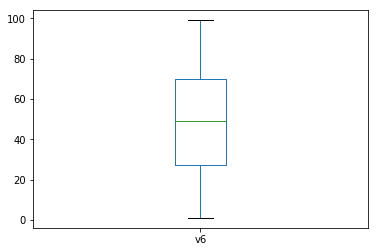

In [32]:
df.v6.plot.box() # look like numerical

In [33]:
df.v45.unique(), df.v12.unique()

(array([0, 1, nan], dtype=object),
 array([ 15. ,   0. ,  99. ,  45. ,  22.5,  31.5]))

v12 looks strange. Maybe it's strange on purpose so that we apply one hot encoding to categorical variables. 

# Ordinal columns (ordered categorical)

In [34]:
df[cols_cato].apply(lambda x: x.nunique())

v13    12
v14    12
dtype: int64

In [35]:
df.loc[1:5, ['v13', 'v14']]

,v13,v14
1,M,RATINGSTUFE M
2,G,RATINGSTUFE G
3,D,RATINGSTUFE D
4,NaN,NaN
5,K,RATINGSTUFE K


In [36]:
df.v14.isnull().sum() == df.v13.isnull().sum()

True

In [37]:
df.v13.unique()

array(['M', 'G', 'D', nan, 'K', 'I', 'F', 'H', 'L', 'E', 'B', 'C', 'A'], dtype=object)

In [38]:
df.v14.unique()

array(['RATINGSTUFE M', 'RATINGSTUFE G', 'RATINGSTUFE D', nan,
       'RATINGSTUFE K', 'RATINGSTUFE I', 'RATINGSTUFE F', 'RATINGSTUFE H',
       'RATINGSTUFE L', 'RATINGSTUFE E', 'RATINGSTUFE B', 'RATINGSTUFE C',
       'RATINGSTUFE A'], dtype=object)

Coincidence? I think not.

In [39]:
# filter rows where trimmed v14 and v13 are not the same 
rows1 = (df.v14.str.replace('RATINGSTUFE ', '') != df.v13)
# are those columns NA? Yes
df.loc[rows1, ['v13', 'v14']].notnull().sum() == 0

v13    True
v14    True
dtype: bool

In [40]:
df.drop('v14', inplace = True, axis = 1)

Recode the ordinal variable. 

In [41]:
df.v13 = df.v13.map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9, 'J':10, 'K':11, 'L':12})

In [42]:
# ordinal variable really but save time and put it into categoricals
cols_cat = cols_cat + ['v13']

In [43]:
# it can be numerical also. qq decide.  
# cols_num = cols_num + ['v13']

# Numerical columns

In [44]:
df[cols_num].describe()

,v19,v8,v16,v7,v27,v29,v35,v17,v24,v4,...,v10,v26,v1,v23,v25,v40,v41,v9,v18,dt_due_paid
count,2388.000000,2572.000000,2388.000000,2571.000000,2388.000000,2388.000000,2388.000000,2388.000000,2388.000000,2572.000000,...,2572.000000,2388.000000,2572.000000,2388.000000,2388.000000,2388.000000,2388.000000,2572.000000,2388.000000,2572.000000
mean,0.429229,193.284992,1.164154,32.246597,1.840452,0.064489,0.087940,0.328727,0.037688,1.000778,...,200.349922,0.340034,33.641913,0.143635,0.021357,0.184255,0.004188,230.280327,0.575377,27.997278
std,0.939083,110.996680,2.922519,11.531376,3.326539,0.381862,0.416226,0.678520,0.207331,0.027880,...,78.806132,0.687397,9.089623,0.556687,0.155759,0.446054,0.064590,114.915400,0.881650,70.743715
min,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,50.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,-264.000000
25%,0.000000,100.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,190.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,190.000000,0.000000,1.000000
50%,0.000000,199.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,199.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,199.000000,0.000000,30.000000
75%,1.000000,199.000000,1.000000,38.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,200.000000,1.000000,30.000000,0.000000,0.000000,0.000000,0.000000,300.000000,1.000000,30.000000
max,7.000000,500.000000,32.000000,86.000000,32.000000,10.000000,8.000000,5.000000,2.000000,2.000000,...,500.000000,5.000000,60.000000,11.000000,3.000000,4.000000,1.000000,600.000000,7.000000,384.000000


qq write code to check if any of the cols above are identical, or simple tranformations of each other (will lead to collinearyt for example)

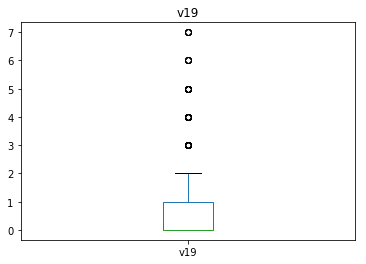

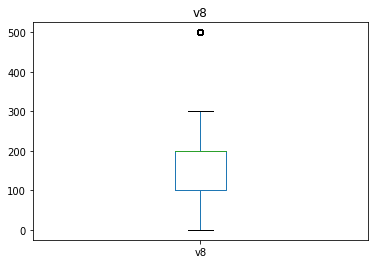

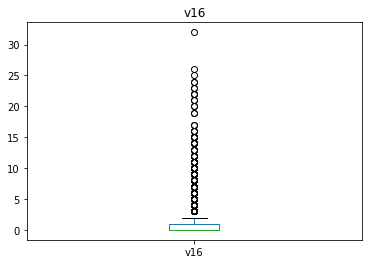

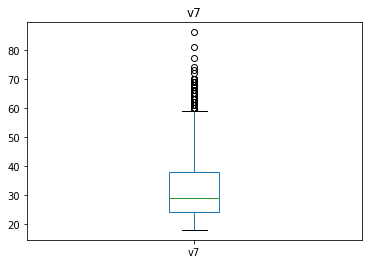

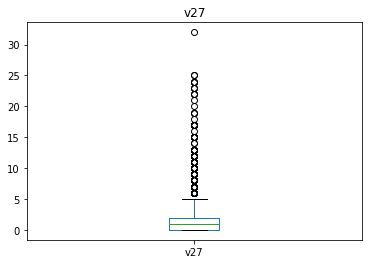

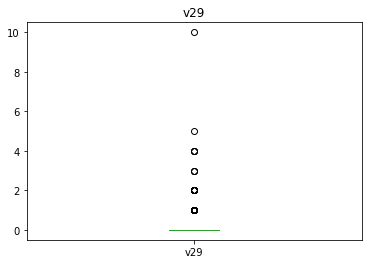

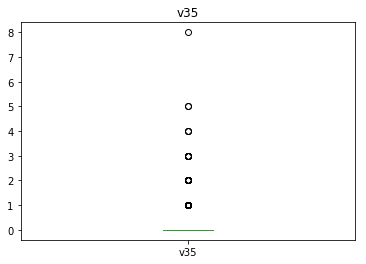

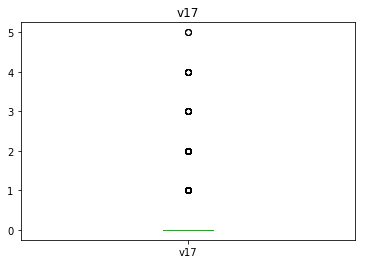

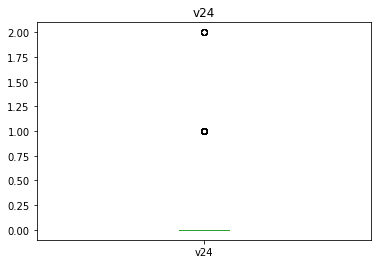

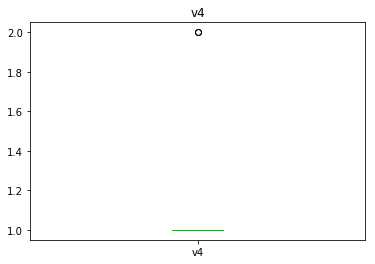

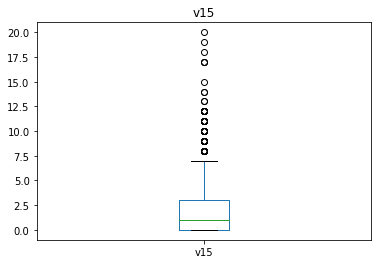

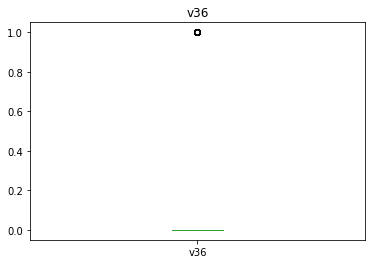

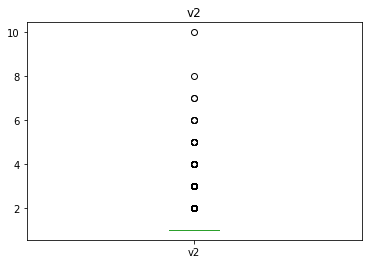

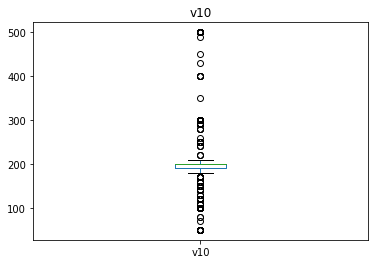

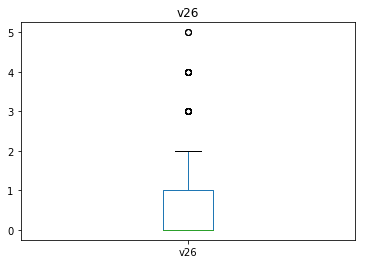

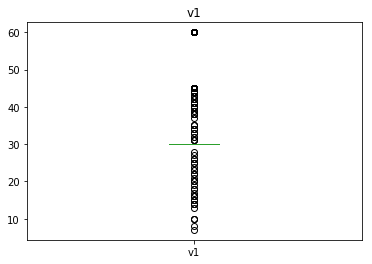

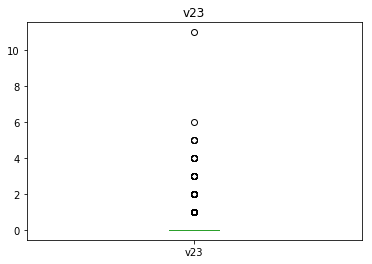

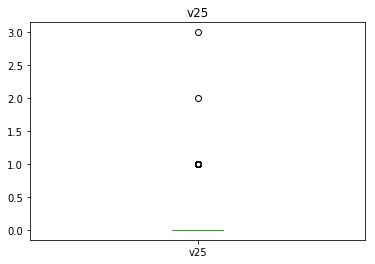

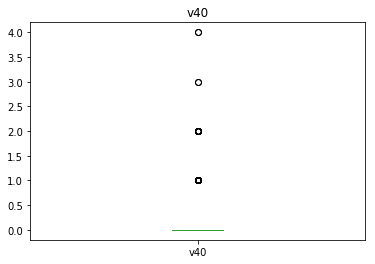

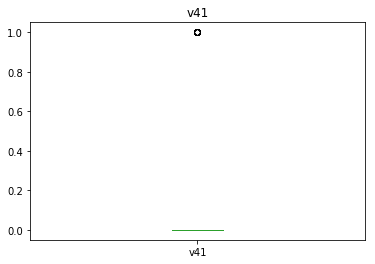

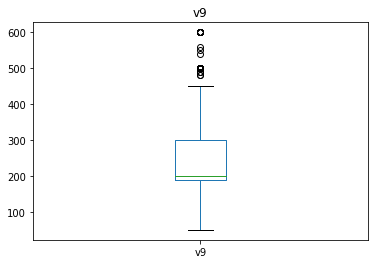

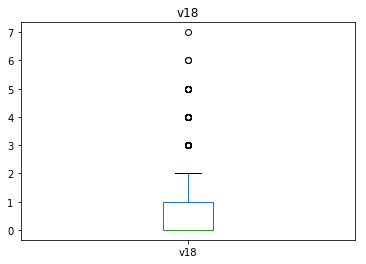

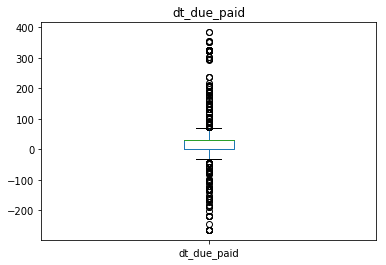

In [45]:
for col in cols_num:
    df[col].plot.box()
    plt.title(col)
    plt.show()

Boxplots look strange for many columns. 

If the nr of unique is too low, it is more likely a categorical column.

Text(0.5,0,'Nr rows / Number of unique')

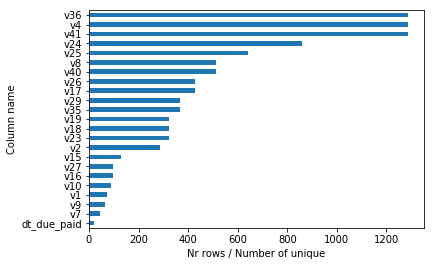

In [46]:
series = df[cols_num].apply(lambda x: n / x.nunique())
series.sort_values().plot.barh()
plt.ylabel("Column name")
plt.xlabel("Nr rows / Number of unique")

In [47]:
df.v36.unique() # looks like a binary variable, not a numerical one - but clf do not care

array([  0.,  nan,   1.])

In [48]:
df.v18.unique() # looks like an (ordered) categorical variable, not a numerical one - but clf do not care

array([  0.,  nan,   1.,   3.,   2.,   4.,   7.,   5.,   6.])

The columns that look like an ordered categorical could be kept as numerical as this is OK for decision trees and for logistic regression we have to assume the impact of class 1 to class 2 is the same as that of class 2 to class 3, etc.

There is a problem, which is illustrated by the box plots, see for example column v12 (it is strange) or columns v35 and v18 (is any of those in reality an ordinal column?). We do not know if the columns are numerical, categorical or ordered categorical. A description was given but we are skeptical if this description correspond to reality. 

To move forward somehow, we put columns intwo two buckets: numerical or categorical. And we will consider a column to be categorical based on the number of unique values. Using the "elbow principle" on the graph above, we pick a threshold and split columns into either numerical or categorical.

In [49]:
# elbow method 
threshold = 200
cols_numlikecat = series[series.values > threshold].index

In [50]:
cols_numlikecat

Index(['v19', 'v8', 'v29', 'v35', 'v17', 'v24', 'v4', 'v36', 'v2', 'v26',
       'v23', 'v25', 'v40', 'v41', 'v18'],
      dtype='object')

# Cols with same nr of NA

In [51]:
# some cols have exactly the same nr of NA. are those columns similar? 
mask = (df.isnull().sum() == 184).values
cols_na184 = df.columns[mask]

In [52]:
cols_na184

Index(['v15', 'v16', 'v17', 'v18', 'v19', 'v23', 'v24', 'v25', 'v26', 'v27',
       'v29', 'v35', 'v36', 'v40', 'v41'],
      dtype='object')

In [53]:
# df.loc[1:20, cols_na147] 

In [54]:
# df.loc[df.v15.isnull() == True].head().T

It might mean something that they have the same number of NA. But what? 

# Different column choices 

Some numerical columns look like categorical, so we can (a) trust the variable descriptions and keep them as numerical, (b) change the so called "numerical" columns that look like categorical into the list of categorical columns. 

Recall that v6 has 96 number of unique. High cardinality can be a problem (increases dimensionality and might cause over-fitting) so we try with & without v6.

In [55]:
# i) the columns chosen based on data cleaning above
cols_num
cols_cat

# ii) move cols_numlikecat from _num into _cat
cols_num2 = list(set(cols_num) - set(cols_numlikecat))
cols_cat2 = list(set(cols_cat) | set(cols_numlikecat))

# iii) move v6 from categorical to numerical.
cols_num3 = cols_num + ['v6']
cols_cat3 = list(set(cols_cat)  -  set(['v6']))

# iv) do both of the above 
cols_num4 = cols_num2 + ['v6']
cols_cat4 = list(set(cols_cat2)  -  set(['v6']))

In [56]:
assert len(cols_num + cols_cat) == len(cols_num2 + cols_cat2)

In [57]:
assert len(cols_num2) + len(cols_numlikecat) == len(cols_num)

In [58]:
len(cols_num), len(cols_cat)

(23, 4)

In [59]:
len(cols_num2), len(cols_cat2)

(8, 19)

In [60]:
len(cols_num3), len(cols_cat3) 

(24, 3)

In [61]:
len(cols_num4), len(cols_cat4) 

(9, 18)

# Select clf

In [62]:
clf = DecisionTreeClassifier() 

In [63]:
clf = RandomForestClassifier()

In [64]:
clf = GradientBoostingClassifier()

In [65]:
clf = LogisticRegression()

In [66]:
clf = LogisticRegression(C = 1.5, penalty = "l1")

All classifiers were similar in their performance. Of course logreg is faster. Since the models are all bad (because AUC = 65%) we will move on with logreg.  Later on we try to use GridSearchCV on the other classifiers to see if their parameters must be tuned in order to be effective for this problem. 

Currently, however, we think the problem lies in our data preparation stage. That might be due to our bad understanding of the data.

The parameters C and penalty was not chosen after hyperparameter tuning, but simply set to `C=1.5` and `penalty="l1"` for theoretical reasons: we want to avoid over-fitting and thus raise the C parameter slightly from its default value, and we use l1 to shrink coef to zero thereby performing a variable selection for us. 

# Select X

We can try out different alternatives. 

In [67]:
numcols = cols_num3
catcols = cols_cat3
usedcols = numcols + catcols

Strangely enough, varying which columns we use do not affect the AUC score.

We chose alternative 3 because even though we suspect some numericals are in fact categorical, we do not know so and stick to the definition provided by `variabletypes`. (Except for the categorical `v6` that we treat as numerical since we do not want to create dummies for the 96 different categories - in addition, the boxplot of v6 look like a nice distrubtion.)

# Fit and predict on test data

In [68]:
# split data
df_train = df[df.y.isnull() == False]
df_test = df[df.y.isnull() == True]

In [69]:
def get_cols(cols):
    return FunctionTransformer(lambda x: x[cols], validate=False)

In [70]:
numerical_pipeline = Pipeline([
    ('select', get_cols(numcols)),
    ('imp', Imputer()),
    ('scale', StandardScaler()
    )
])

categorical_pipeline = Pipeline([
    ('select', get_cols(catcols)),
    ('imp', Imputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')) 
    # OneHotEncoder(handle_unknown = 'ignore') is needed for cols_cat2
])

union = FeatureUnion([
    ('numeric', numerical_pipeline),
    ('categorical', categorical_pipeline)
])

pl = Pipeline([
    ('union', union),
    ('clf', clf)
])

The numerical pipeline could contain a LDA step to reduce dimensionality. We could also use an ensemble of classifiers, for example both trees and regression, and average their predictions. This can make the final predicitons slighly better.

In [71]:
X = df_train[numcols + catcols]
y = df_train.y

cv = cross_val_score(pl, X, y, cv = 10, scoring='roc_auc')
print("nr numerical: ", len(numcols))
print("nr categorical: ", len(catcols))
print(cv.mean(), cv.std())

nr numerical:  24
nr categorical:  3
0.670864339592 0.0272540165156


In [72]:
pl.fit(X, y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False,
          func=<function get_cols.<locals>.<lambda> at 0x7fc1dcc0a6a8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
    ...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## Coef

Text(0,0.5,'Coef estimate')

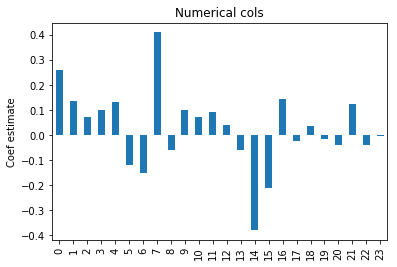

In [73]:
coefs = pd.Series(clf.coef_.tolist()[0])
coefs[coefs.index < len(numcols)].plot.bar()
plt.title("Numerical cols")
plt.ylabel("Coef estimate")

In [74]:
print("Penalty l1 de-selected", (clf.coef_ == 0).sum(), " out of ", len(numcols + catcols), " variables.")

Penalty l1 de-selected 4  out of  27  variables.


In [75]:
# X.columns for the decision tree
# pd.Series(pl.named_steps['clf'].feature_importances_).sort_values(ascending=False).plot.barh()
# pl.steps[1][1].get_feature_names()

# Submit 

In [76]:
assert len(df_test) == 2572-2058+1 # given in instructions

In [77]:
# test set
X_test = df_test[numcols + catcols]

In [78]:
# fit the model on all data in our training set
pl.fit(X, y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('select', FunctionTransformer(accept_sparse=False,
          func=<function get_cols.<locals>.<lambda> at 0x7fc1dcc0a6a8>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
    ...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [79]:
# predict on the data in our test set 
y_pred_proba = pl.predict_proba(X_test)[:, 1]

In [80]:
# submit predictions
pd.DataFrame({'Appplication_ID':df_test['application_id'], 
              'Proba':y_pred_proba}
            ).set_index('Appplication_ID').to_csv('submit/submit_jacob.csv')